In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e6/sample_submission.csv
/kaggle/input/playground-series-s4e6/train.csv
/kaggle/input/playground-series-s4e6/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e6/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e6/test.csv")

sample = pd.read_csv("/kaggle/input/playground-series-s4e6/sample_submission.csv")

In [3]:
train_df.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

All of our variables (except Target) is recorded as a float or integer. When going through the dataset information we see that some of these variables are ordinal, some are categorical, and some are numerical. We'll need to set up a pipeline to be able to properly categorize each of our variables so that they can be normalized for our model. No missing or null variables so we can do some scoping to make sure everything will process correctly however I trust the dataset source so it should be okay - rigorous preprocessing was already performed on the dataset by Instituto Politécnico de Portalegre (Political Institute of Portugal). 

Per our dataset information we have a 80/20 split between our train and test datasets. In addition, we likely would want to drop the ID variable since we are using tabular data so the id is not necessary and would just be noise for our model. We'll do our EDA first and then build a baseline model in NumPy, then an ensemble model with Sci-Kit Learn, and finally a Neural Network using TensorFlow. To be able to properly see/access our results within the competition our ensemble method and Neural Network will be contained in separate notebooks for upload + score. 

Our Target is an ordinal categorical column as well - 1 = Dropout, 2 = Enrolled, 3 = Graduate 

In [5]:
train_df.describe()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,...,76518.00000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000
mean,38258.500000,1.111934,16.054419,1.644410,9001.286377,0.915314,3.658760,132.378766,1.226600,19.837633,...,0.05796,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921
std,22088.988286,0.441669,16.682337,1.229645,1803.438531,0.278416,8.623774,10.995328,3.392183,15.399456,...,0.40849,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382
min,0.000000,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,19129.250000,1.000000,1.000000,1.000000,9119.000000,1.000000,1.000000,125.000000,1.000000,1.000000,...,0.00000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,38258.500000,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,...,0.00000,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,57387.750000,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,140.000000,1.000000,37.000000,...,0.00000,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000
max,76517.000000,6.000000,53.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,...,12.00000,19.000000,23.000000,33.000000,20.000000,18.000000,12.000000,16.200000,3.700000,3.510000


In [6]:
train_df.columns

Index(['id', 'Marital status', 'Application mode', 'Application order',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units

Ordinal Variables:

Application Order,
Previous Qualification,
Mother's Qualification,
Father's Qualification


Categorical Variables:

Marital Status,
Application Mode,
Nacionality,
Course,
Mother's Occupation,
Father's Occupation

Boolean Variables:

Daytime/evening attendance,
Displaced,
Educational special needs,
Debtor,
Tuition fees up to date,
Gender,
Scholarship holder,
International


Numerical Variables:

Previous qualification (grade),
Admission grade,
Age at enrollment,

Curricular units 1st sem (credited),
Curricular units 1st sem (enrolled),
Curricular units 1st sem (evaluations),
Curricular units 1st sem (approved),
Curricular units 1st sem (grade),
Curricular units 1st sem (without evaluations),

Curricular units 2nd sem (credited),
Curricular units 2nd sem (enrolled),
Curricular units 2nd sem (evaluations),
Curricular units 2nd sem (approved),
Curricular units 2nd sem (grade),
Curricular units 2nd sem (without evaluations),

Unemployment Rate,
Inflation Rate,
GDP

In [7]:
ord_cols = ["Application order", "Previous qualification", "Mother's qualification", "Father's qualification"]

cat_cols = ["Marital status", "Application mode", "Nacionality", "Course", "Mother's occupation", "Father's occupation", 
            "Daytime/evening attendance", "Displaced", "Educational special needs", "Debtor", "Tuition fees up to date", 
            "Gender", "Scholarship holder", "International"]

num_cols = ["Previous qualification (grade)", "Admission grade", "Age at enrollment", 
            "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)", "Curricular units 1st sem (evaluations)", 
            "Curricular units 1st sem (approved)", "Curricular units 1st sem (grade)", "Curricular units 1st sem (without evaluations)", 
            "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (enrolled)", "Curricular units 2nd sem (evaluations)", 
            "Curricular units 2nd sem (approved)", "Curricular units 2nd sem (grade)", "Curricular units 2nd sem (without evaluations)", 
            "Unemployment rate", "Inflation rate", "GDP"]

target = ["Target"]

In [8]:
train_df[target].head()

,Target
0,Graduate
1,Dropout
2,Dropout
3,Enrolled
4,Graduate


**Imports**

In [63]:
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

# Numerical Variables

In [10]:
def plot_histograms(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(4, 2))
        plt.hist(df[col], bins=25, color='lightgreen', edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

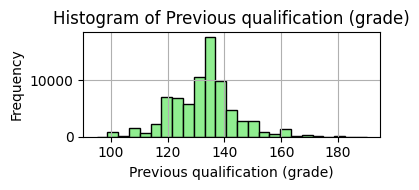

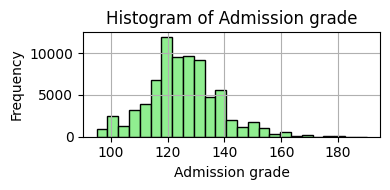

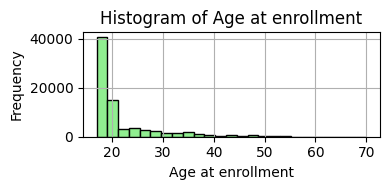

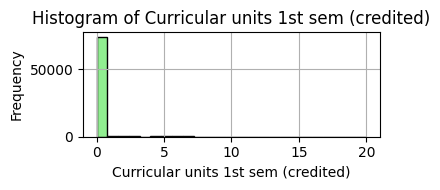

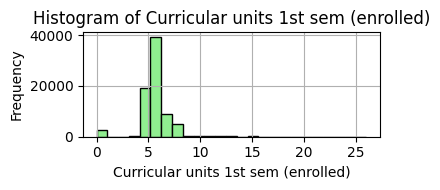

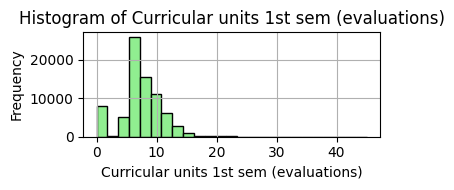

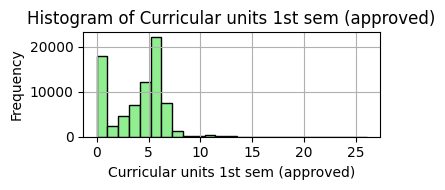

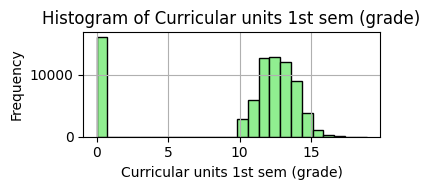

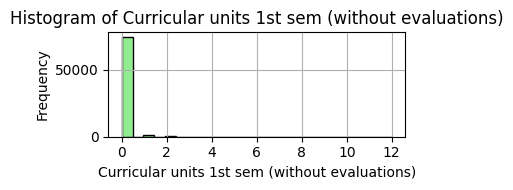

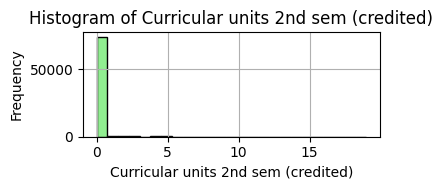

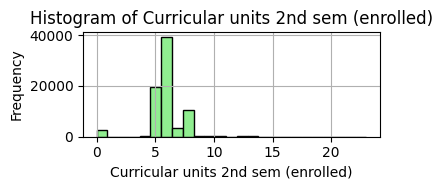

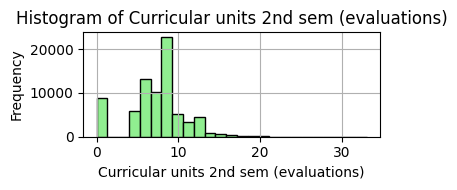

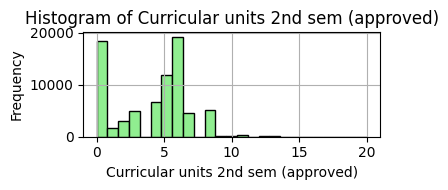

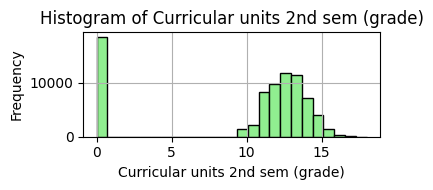

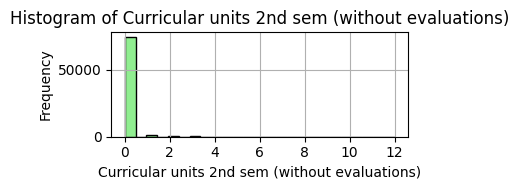

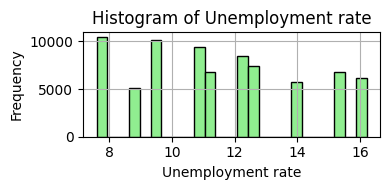

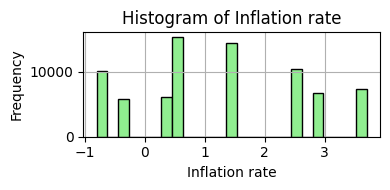

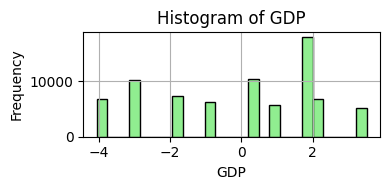

In [11]:
plot_histograms(train_df, num_cols)

In [12]:
def plot_boxplots(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(4, 2))
        sns.boxplot(x=df[col], color='red')
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.grid(True)
        plt.show()

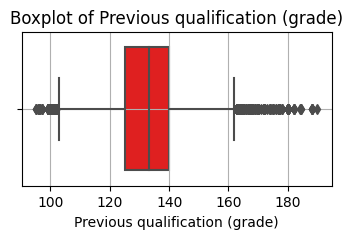

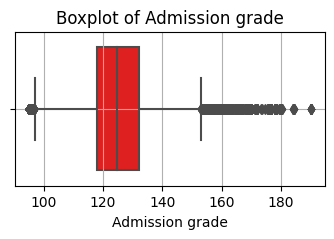

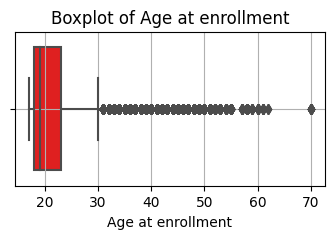

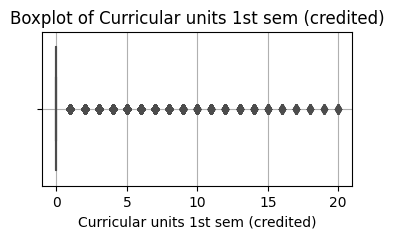

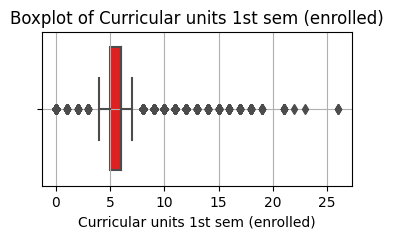

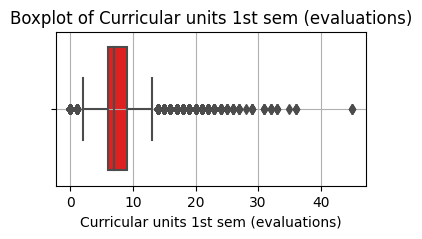

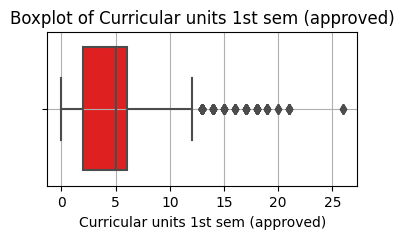

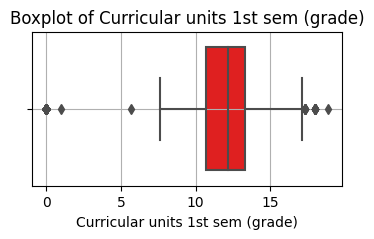

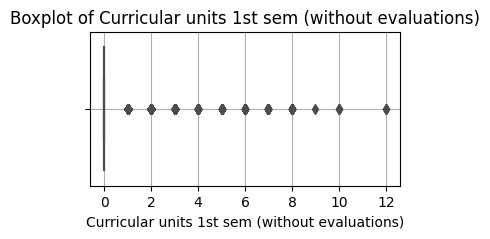

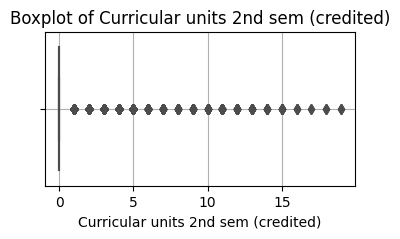

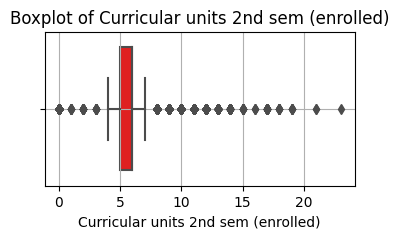

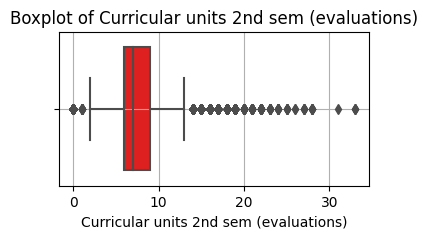

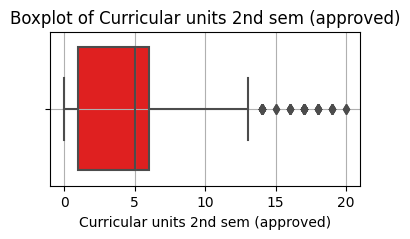

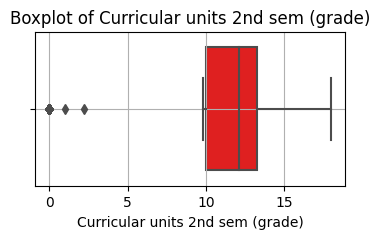

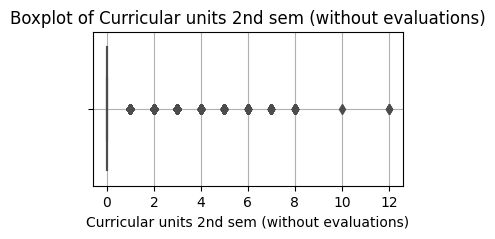

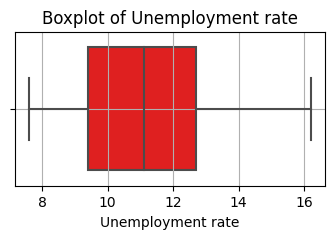

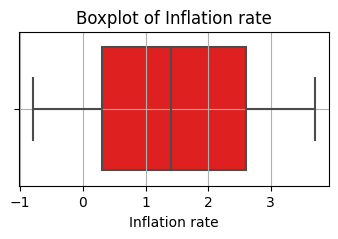

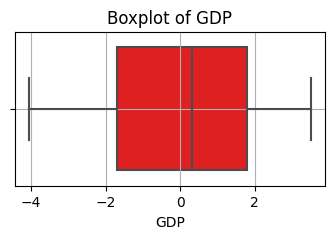

In [13]:
plot_boxplots(train_df, num_cols)

Our boxplots for our curricular units data all show a high amount of outliers that may affect the model if left unchecked. Our economic data is all outlier free and the distributions for our admission grade and previous qualification are all normal, so we should focus on the data with outliers or abnormal distributions first. Since this is numerical data it may be corrected via our standard scaler but likely will still need more fine tuning to prevent mischaracterizations of data points in our model. 

# Categorical Variables

In [14]:
def create_bargraphs(data, cat_cols):
    for col in cat_cols:
        data[col] = pd.Categorical(data[col], ordered=True)
        category_counts = data[col].value_counts().sort_index()
        plt.figure(figsize=(6, 4))
        category_counts.plot(kind='bar')
        plt.title(f'Bar Graph for {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.xticks(rotation=90, fontsize=6)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

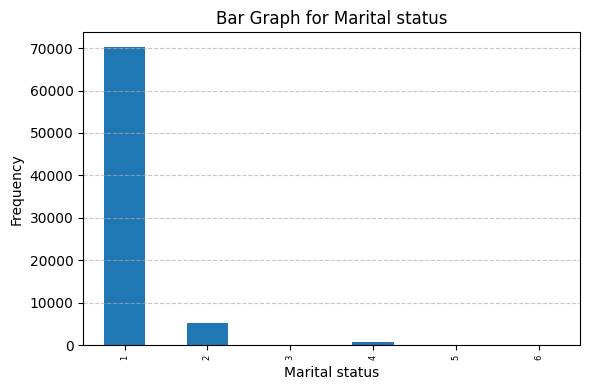

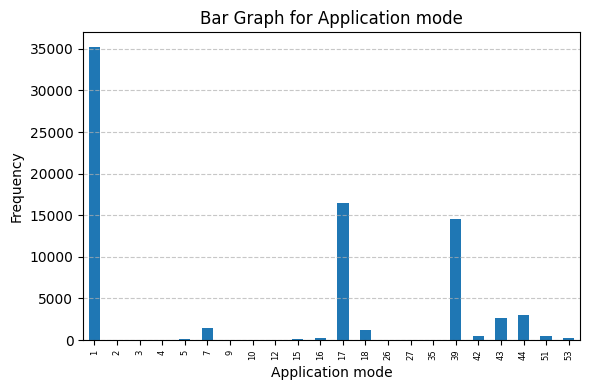

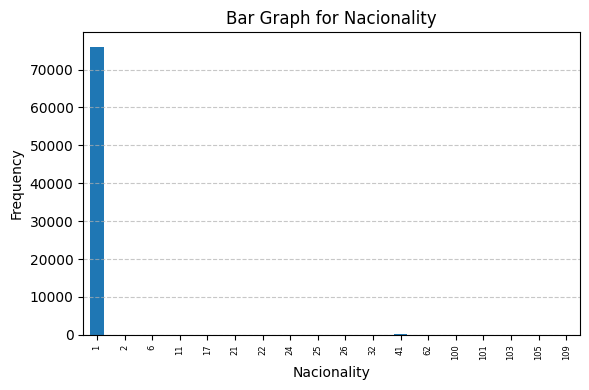

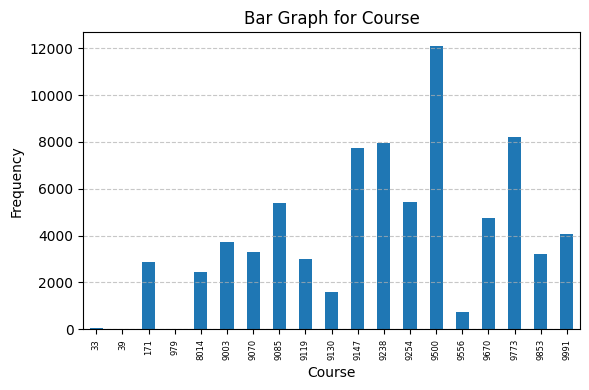

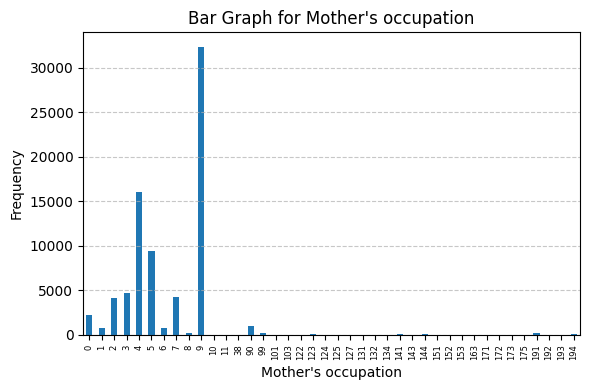

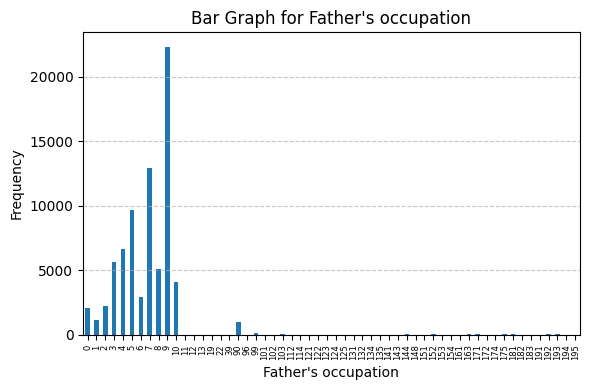

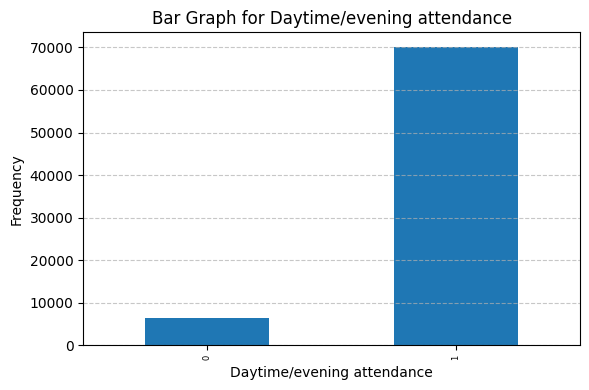

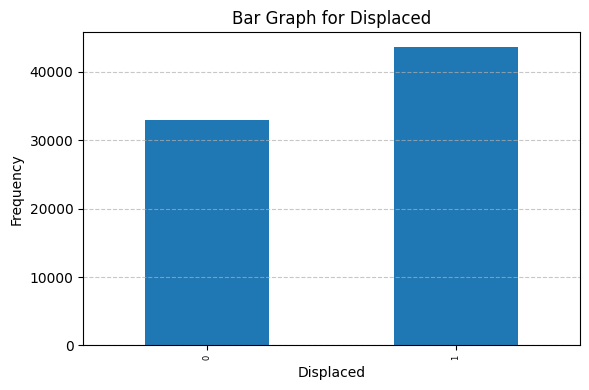

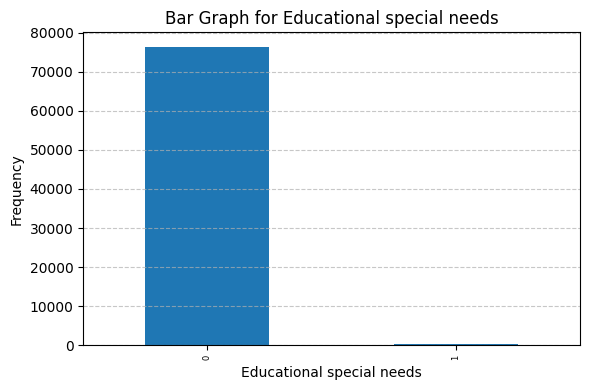

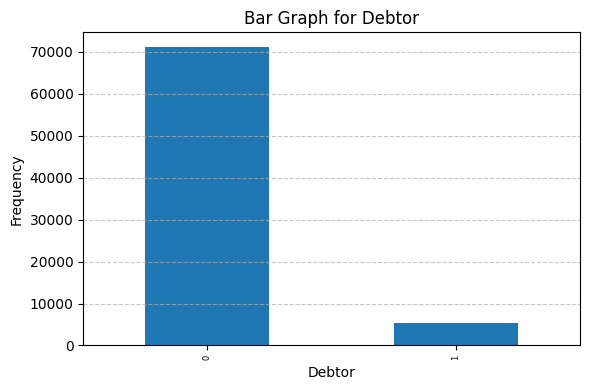

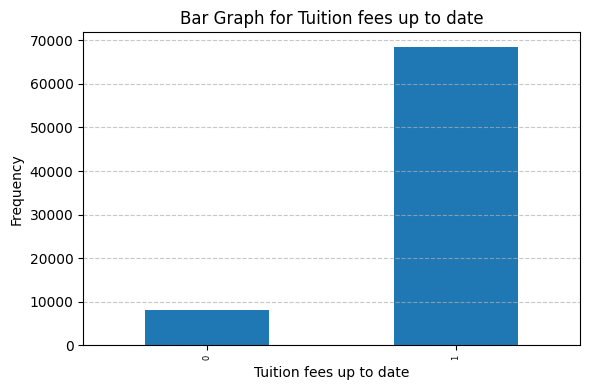

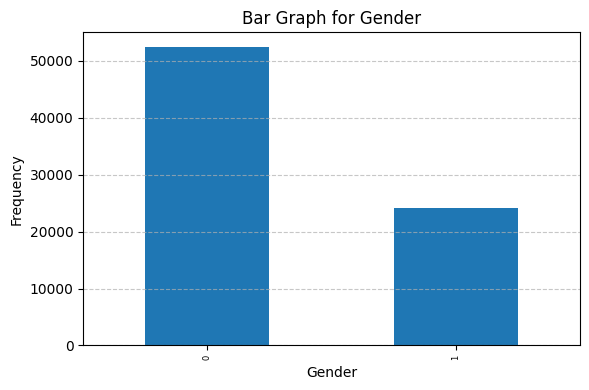

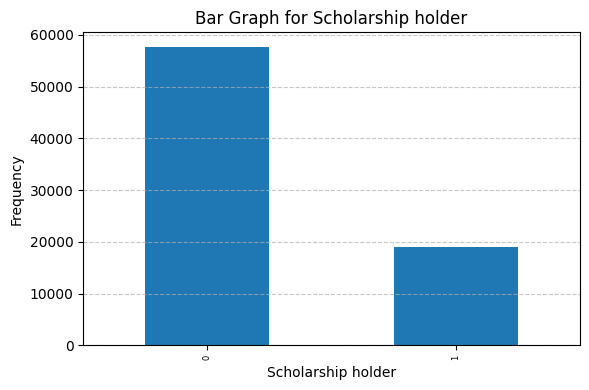

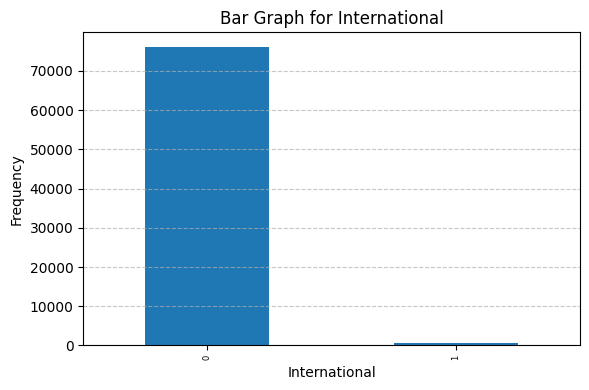

In [15]:
create_bargraphs(train_df, cat_cols)

# Ordinal Variables

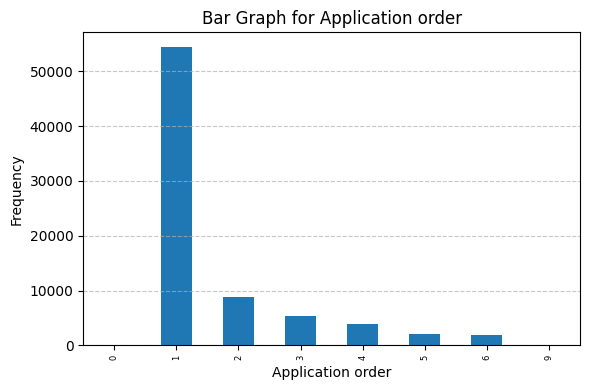

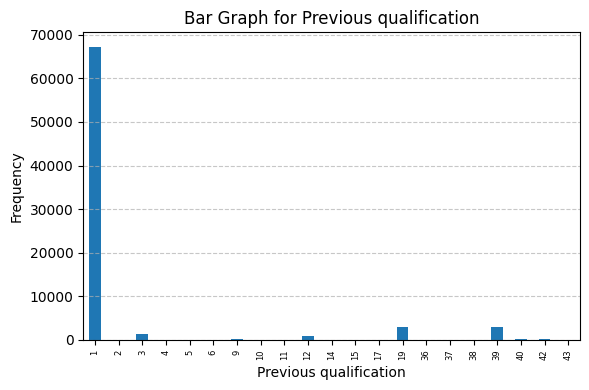

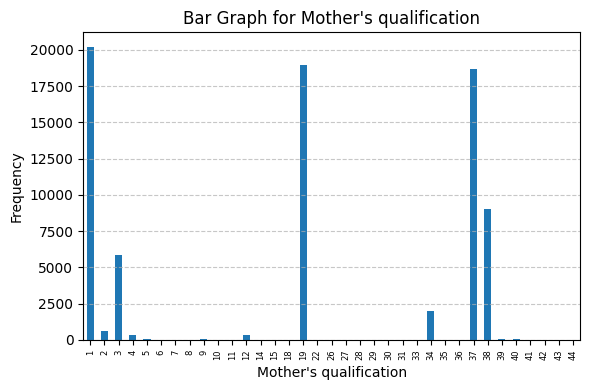

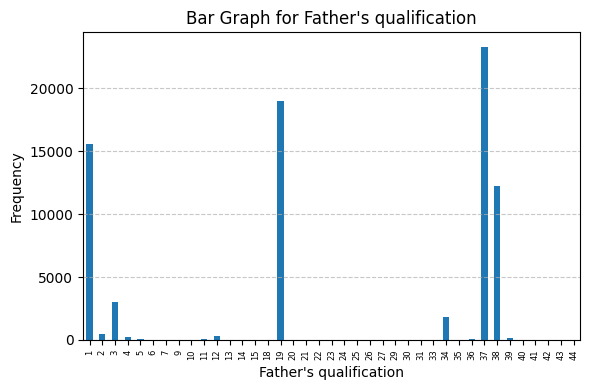

In [16]:
create_bargraphs(train_df, ord_cols)

Our categorical data has multiple columns with abnormal frequencies that may affect our model via our training data, we will want to ensure our model is as robust as possible and train it on as many different points as we have available, because of this we may want to look at k-fold or cross-fold validation to ensure that we are accessing all relevant data points in the training, testing, and validation phases. 

# Target

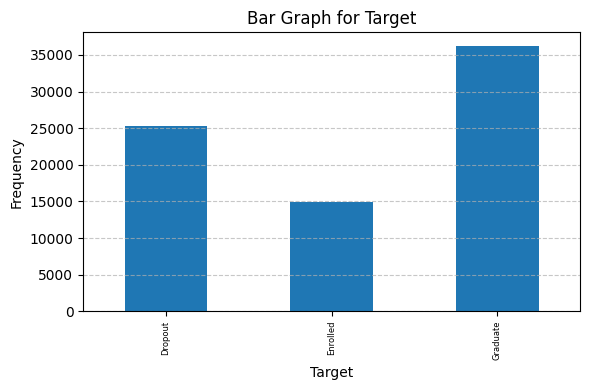

In [17]:
create_bargraphs(train_df, target)

High frequency in our target data for the Graduate category which can adversly affect our model output we should definitely consider kernels and clustering algorithms to ensure our target is not heavily reliant on only one or two categories, but can accurately assess our data and produce the correct target category.

In [18]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)

,0
id,0
Curricular units 2nd sem (credited),0
International,0
Curricular units 1st sem (credited),0
Curricular units 1st sem (enrolled),0
Curricular units 1st sem (evaluations),0
Curricular units 1st sem (approved),0
Curricular units 1st sem (grade),0
Curricular units 1st sem (without evaluations),0
Curricular units 2nd sem (enrolled),0


No Null values

# Notes for model

We have a few issues present:


1. Our target has a high frequency in one of three options (Graduate) and the Enrolled target variable is far lower than the other two, this can cause a model to disregard the Enrolled target making its accuracy far lower


2. Many of our feature variables have outliers, non-normal distributions, or high frequencies in one category over others which again would negatively effect the output of our model. Once we pipeline our features into scaling, one-hot encoding, or ordinal encoding imputers we may see some regularization but it is likely not going to be enough.


Solutions:


1. Smoothing or stratifying our target variable outcomes so that our model is likely to correctly predict the right output within statistical relevance


2. Clustering algorithms, such as K-means for our numerical variables, for our features so that we can represent data at each relevancy point to inform our model on which features relate to which outputs the most. 


3. Need to check multiple evaluation metrics not just accuracy. F-1 score, Precision, and Recall will all be vital to ensuring we have a robust model that can accurately predict the target variable. 

# Feature Engineering

A few points we need to check - 


1. The skewness of our curriculum units data is likely due to a high-frequency of 0's.. we should check to see if this is due to a specific target outcome (most likely dropout or graduate) and work from there to be able to normalize the data in a way that our model can use it effectively. 


2. We have outliers in our categorical data as well, we should ensure when we one-hot encode we still have most/all of our potential inputs for our model with kfolds or cross-validation.


3. We need to find our most important features for informing our model.

# Pipeline

In [19]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [20]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ord_cols),
    ('ohe_p', ohe_pipeline, cat_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [21]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [22]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)

,0
id,0
Curricular units 2nd sem (credited),0
International,0
Curricular units 1st sem (credited),0
Curricular units 1st sem (enrolled),0
Curricular units 1st sem (evaluations),0
Curricular units 1st sem (approved),0
Curricular units 1st sem (grade),0
Curricular units 1st sem (without evaluations),0
Curricular units 2nd sem (enrolled),0


# Model Building

In [23]:
X = train_df.drop(columns=['id', 'Target'], axis=1)
y = train_df['Target']

In [49]:
X.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

In [24]:
"""y = pd.get_dummies(train_df['Target'], dtype = int)"""

"y = pd.get_dummies(train_df['Target'], dtype = int)"

In [25]:
print(y)

0        Graduate
1         Dropout
2         Dropout
3        Enrolled
4        Graduate
           ...   
76513    Graduate
76514    Graduate
76515    Enrolled
76516     Dropout
76517    Graduate
Name: Target, Length: 76518, dtype: category
Categories (3, object): ['Dropout' < 'Enrolled' < 'Graduate']


In [54]:
X_preprocessed = pipeline.fit_transform(X)

In [55]:
X_preprocessed.shape

(76518, 199)

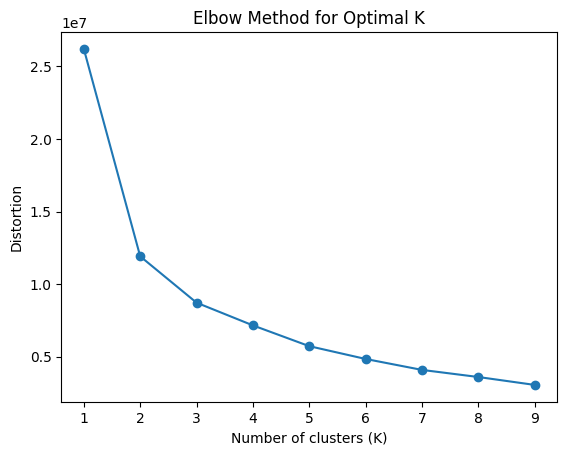

In [27]:
from sklearn.cluster import KMeans

distortions = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(X_preprocessed)
    distortions.append(kmeans.inertia_) 
    
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()

9 clusters should work for our dataset

In [28]:
"""distortions = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(y)
    distortions.append(kmeans.inertia_) 
    
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()"""

'distortions = []\nK_range = range(1, 10)\nfor k in K_range:\n    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")\n    kmeans.fit(y)\n    distortions.append(kmeans.inertia_) \n    \nplt.plot(K_range, distortions, marker=\'o\')\nplt.xlabel(\'Number of clusters (K)\')\nplt.ylabel(\'Distortion\')\nplt.title(\'Elbow Method for Optimal K\')\nplt.show()'

Only need 3 clusters for our target variable

In [29]:
#X_preprocessed

kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto")
kmeans.fit(X_preprocessed)
x_cluster_labels = kmeans.labels_
print(x_cluster_labels)

[0 7 0 ... 8 8 7]


In [30]:
#Target Preprocessed (we're not going to use this for now, just regular label encoding below)
"""
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")
kmeans.fit(y)
y_cluster_labels = kmeans.labels_
print(y_cluster_labels)"""

'\nkmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")\nkmeans.fit(y)\ny_cluster_labels = kmeans.labels_\nprint(y_cluster_labels)'

In [31]:
X_with_clusters = np.c_[X, x_cluster_labels]

label_mapping = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
encoded_y = y.map(label_mapping)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, encoded_y, test_size=0.15, random_state=25)

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)
clf.fit(X_train, y_train)

sgd_pred = clf.predict(X_test)

reverse_label_mapping = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}

decoded_pred = [reverse_label_mapping[label] for label in sgd_pred]

decoded_test = [reverse_label_mapping[label] for label in y_test]
#print(decoded_pred)

#sgd_pred = np.argmax(sgd_pred, axis=1)
#y_test = np.argmax(y_test, axis=1)

#score = clf.score(y_test, sgd_pred)

#print(1 - np.sum(np.absolute(sgd_pred - y_test)) / y_pred.shape [0])


accuracy = accuracy_score(decoded_test, decoded_pred)

print("Accuracy:", accuracy)
#print(sgd_pred)

Accuracy: 0.8070221292908172


In [61]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

print(rfc_pred)

decoded_pred_rfc = [reverse_label_mapping[label] for label in rfc_pred]

accuracy_rfc = accuracy_score(decoded_test, decoded_pred_rfc)

print("Accuracy:", accuracy_rfc)

[0 1 0 ... 2 0 2]
Accuracy: 0.829064296915839


In [64]:
cbc = CatBoostClassifier(verbose=0)

cbc.fit(X_train, y_train)

cbc_pred = cbc.predict(X_test)

flattened = []

for arr in cbc_pred:
    flattened.extend(arr)

#print(flattened)

decoded_pred_cbc = [reverse_label_mapping[label] for label in flattened]

accuracy_cbc = accuracy_score(decoded_test, decoded_pred_cbc)

print("Accuracy:", accuracy_cbc)

Accuracy: 0.835250043561596


# Submission

In [56]:
test_df_preprocessed = test_df.drop("id", axis=1)

test_df_preprocessed = pipeline.transform(test_df_preprocessed)

In [57]:
test_df_preprocessed.shape

(51012, 199)

In [66]:
sub_pred = cbc.predict(test_df_preprocessed)

flattened_sub = []

for arr in sub_pred:
    flattened_sub.extend(arr)

decoded_sub = [reverse_label_mapping[label] for label in flattened_sub]

submission = pd.DataFrame({'id': test_df['id'], 'Target': decoded_sub})

print(submission.head())
print(f"Submission data shape: {submission.shape}")

submission.to_csv('submission.csv', index=False)

      id    Target
0  76518   Dropout
1  76519  Graduate
2  76520  Graduate
3  76521  Graduate
4  76522  Enrolled
Submission data shape: (51012, 2)
